# Experiment 3 - Scene Splitting

In [1]:
%matplotlib notebook
from math import sqrt
import numpy as np
import scipy
import glob
import cv2
import matplotlib
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize as imresize
from bitstring import BitArray, BitStream

##### Support Functions

In [2]:
# implement 2D DCT
def dct2(img):
    from scipy.fftpack import dct
    return dct(dct(img.T, norm='ortho').T, norm='ortho')

# implement 2D IDCT
def idct2(img):
    from scipy.fftpack import idct
    return idct(idct(img.T, norm='ortho').T, norm='ortho')   

def diag_gen(nsides):
    x, y = 0, 0
    upright = True
    visits = 1
    while visits <= nsides**2:
        yield (x,y)
        visits += 1
        if upright:
            x, y = x - 1, y + 1
        else:
            x, y = x + 1, y - 1
        #yield (0, x, y)
        if 0 <= x < nsides:
            if 0 <= y < nsides:
                continue
            elif 0 < y:
                x += 2
                y -= 1
            else:
                y = 0
        elif 0 < x:
            if 0 <= y < nsides:
                x -= 1
                y += 2
            elif 0 < y:
                raise Exception("this shouldn't happen ({}, {})".format(x, y))
            else:
                x -= 1
                y += 2
        else:
            if 0 <= y < nsides:
                x = 0
            elif 0 < y:
                x += 2
                y = nsides-1
            else:
                raise Exception("this shouldn't happen ({}, {})".format(x, y))
        upright = not upright

# Image Hasher

In [3]:
# must be already grayscale
def img_to_hash(img_full, resizeTo=64, cropTo=16, plot=False):
    #img_full = rgb2gray(imread(src))
    img_base = imresize(img_full, (resizeTo,resizeTo))
    img_base -= 0.5
    
    img_freq = dct2(img_base)
    amortize = np.vectorize(lambda x: np.sign(x)*sqrt(abs(x)))
    img_freq_crop = img_freq[0:cropTo,0:cropTo]
    img_freq_amort = amortize(img_freq_crop)
    
    freq_avg = img_freq_amort.mean()
    f = lambda x: x > freq_avg
    img_freq_final = f(img_freq_amort)
    
    hash_val = "0b"
    for (x, y) in diag_gen(cropTo):
        hash_val += str(int(img_freq_final[x][y]))
    hash_val = BitArray(hash_val)
    
    if plot:
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(9,16))
        # The -5 and +5 were determined "experimentally"
        ax1.set_title('Input Image')
        ax1.imshow(img_full, cmap='gist_gray')
        ax2.set_title('Final Freq Map')
        ax2.imshow(img_freq_final)
        
        ax3.set_title('Cos Freq Map')
        ax3.imshow(img_freq)
        ax4.set_title('Inverse')
        ax4.imshow(idct2(img_freq), cmap='gist_gray')        
        
        ax5.set_title('Cropped Cos Fre Map')
        ax5.imshow(img_freq_crop)
        ax6.set_title('Inverse')
        img_freq_crop2 = np.zeros((resizeTo,resizeTo))
        img_freq_crop2[0:cropTo,0:cropTo] = img_freq_crop
        ax6.imshow(idct2(img_freq_crop2), cmap='gist_gray')
        
        ax7.set_title('Amortized Cos Fre Map')
        ax7.imshow(img_freq_amort)
        ax8.set_title('Inverse')
        img_freq_amort2 = np.zeros((resizeTo,resizeTo))
        invf = np.vectorize(lambda x: np.sign(x)*x**2)
        img_freq_amort2[0:cropTo,0:cropTo] = invf(img_freq_amort)
        ax8.imshow(idct2(img_freq_amort2), cmap='gist_gray')
        #ax8.imshow(img_freq_amort2)
    
        plt.tight_layout()
        plt.subplots_adjust(top=0.925)
        fig.suptitle('Test image - Final perceptual hash 0x{}...'.format(hash_val.hex[0:32]))
    
    return hash_val


hash_val = img_to_hash(rgb2gray(imread('../test-media/cat.png')), plot=True)
print(hash_val)

<IPython.core.display.Javascript object>

0xfe63328fb5718568ead2ae2e9a8618630a7559abd2554ab881c3e7c20c107fd9


# Process Video

In [4]:
def hamming_dist(a,b):
    """Calculate the Hamming distance between two bit strings"""
    assert len(a.bin) == len(b.bin)
    count = 0
    return (a^b).count(1) #XOR

## Extract Frames

In [5]:
vidcap = cv2.VideoCapture('../test-media/vids/Caminandes_2-Z4C82eyhwgU.webm')
success,image = vidcap.read()
if not success:
    raise Exception("failed to open video")
fps = vidcap.get(cv2.CAP_PROP_FPS)

print("Video FPS: {}".format(fps))

last_hash = None
frames = []
frames_hash_diff = [0]
while success:
    success, image = vidcap.read()
    if success:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        frames.append(image)
        hash_val = img_to_hash(image)
        if last_hash is not None:
            frames_hash_diff.append(hamming_dist(last_hash, hash_val))
        last_hash = hash_val

print("Video frame length: {}".format(len(frames)))
print("Video time length: {} s".format(len(frames)/fps))

Video FPS: 24.0
Video frame length: 3326
Video time length: 138.58333333333334 s


## Plot Frame Hash over time

<IPython.core.display.Javascript object>


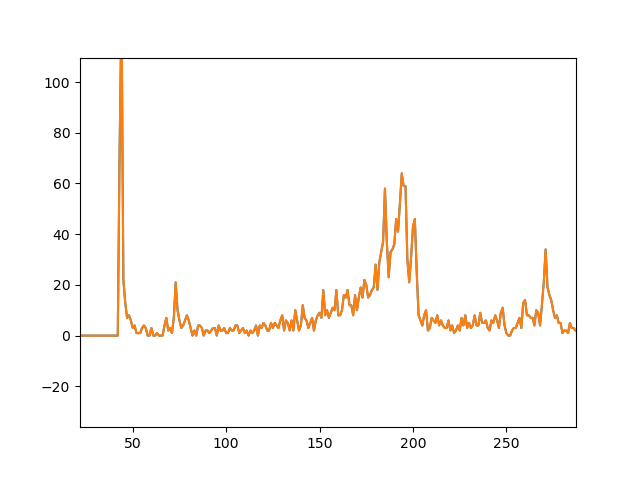

Min: 0
Avg: 13.93144918821407
STD: 22.941744116245467
max: 156


In [9]:
fig, ax1 = plt.subplots(1)
print("Min: {}".format(np.min(frames_hash_diff)))
print("Avg: {}".format(np.mean(frames_hash_diff)))
print("STD: {}".format(np.std(frames_hash_diff)))
print("max: {}".format(np.max(frames_hash_diff)))
ax1.plot(frames_hash_diff)
# ax2.imshow(frames[42], cmap='gist_gray')
# ax3.imshow(frames[44], cmap='gist_gray')
fig.show()

In [7]:
# alg for determining break pointslength/time.
# target_scene

Possible values for paramenters: target scene time $S_{tt} = 5\text{ min} = 300\text{ s}$, minimum scene length: $S_{\min t} = 10\text{ s}$.

Greedy algorithm for finding breakpoints: (time only)

1. $N_b = V_t/S_{tt}$ where $N_{tb}$ is the target number of breakpoints, $V_t$ is the video length/time, $S_{tt}$ scene target length/time.
2. For $0 <= i < N_{tb}$
    1. For each frame in order of hamming difference:
        1. If there is a near breakpoint, skip to the next candidate. (near is less then $S_{\min t}$, i.e. the minimum scene duration)
        2. Assign this frame as a new breakpoint.

Idealy, we would want something that tries to divide the video into scenes of "equal change" (i.e. equal sum of hamming distances) *and* equal length.

Better alg idea: (still suboptimal)

1. Use the cost function $c(f_0, f) = \int_{f_0}^f h_d(t) \text{d}t$ where $h_d(f)$ is the perceptual hash hamming distance between frame $f$ and $f-1$.
2. Compute the total video cost $C_v$ and the target scene cost $C_s = C_v/(V_t \times S_{tc})$ where $V_t$ is the video length/time, $S_{tc}$ scene target cost. (
3. For each frame $f$, make it a breakpoint if $c(f_0, f) \ge C_s$, where $f_0$ is the last breakpoint, and $f-f_0 \ge S_{\min t}$.

+ 179 (cost 1000)
+ 251 (cost 1124)
+ 329 (cost 1001)
+ 401 (cost 1063)
+ 473 (cost 2986)
+ 545 (cost 2001)
+ 668 (cost 1003)
+ 744 (cost 1057)
+ 832 (cost 1003)
+ 920 (cost 1017)
+ 1033 (cost 1005)
+ 1105 (cost 1777)
+ 1177 (cost 1038)
+ 1249 (cost 1897)
+ 1321 (cost 1954)
+ 1393 (cost 1069)
+ 1465 (cost 1807)
+ 1695 (cost 1076)
+ 1900 (cost 1001)
+ 1972 (cost 1925)
+ 2044 (cost 1909)
+ 2119 (cost 1001)
+ 2191 (cost 2563)
+ 2318 (cost 1006)
+ 2409 (cost 1005)
+ 2481 (cost 2626)
+ 2553 (cost 1137)
+ 2943 (cost 1034)
+ 3023 (cost 1005)
+ 3095 (cost 3848)
+ 3211 (cost 1082)


<IPython.core.display.Javascript object>


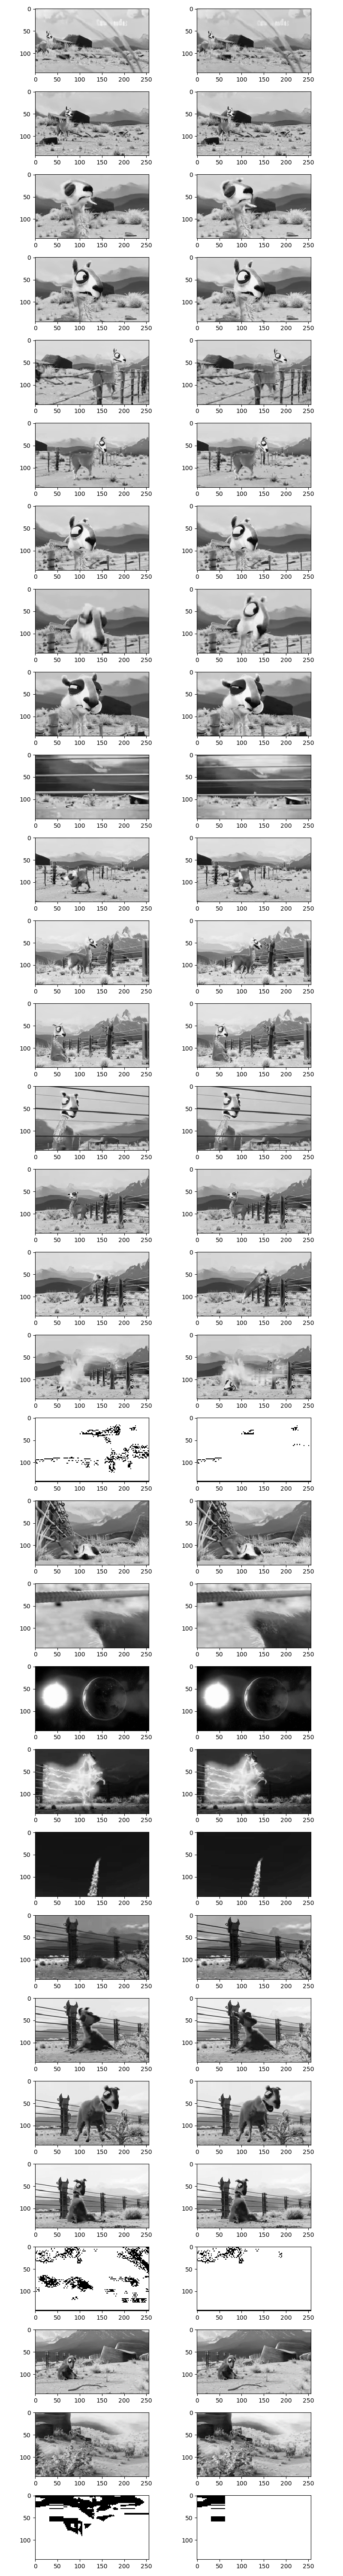

In [17]:
video_length = len(frames)
video_cost_total = sum(frames_hash_diff)
video_cost_average = video_cost_total/video_length
scene_length_min = 3*fps
#scene_length_target = 300*fps
#scene_count_target = video_length/scene_length_target
scene_cost_target = 1000 #?

# print("video_length = {} frames".format(video_length))
# print("video_cost_total = {} bits of change".format(video_cost_total))
# print("scene_length_min = {} frames".format(scene_length_min))
# print("scene_length_target = {} frames".format(scene_length_target))
# print("scene_count_target = {} scenes".format(scene_count_target))
# print("scene_cost_target = {} bits of change".format(scene_cost_target))

cur_cost = 0
last_break = 0
breakpoints = []
#print("Target scene cost: {}".format(scene_count_target))
for i in range(video_length):
    cur_cost += frames_hash_diff[i]
    if cur_cost >= scene_cost_target and i-last_break >= scene_length_min:
        breakpoints.append(i)
        print("+ {} (cost {})".format(i, cur_cost))
        cur_cost = 0
        last_break = i

fig, ax = plt.subplots(len(breakpoints), 2, figsize=(8,60))
for i in range(len(breakpoints)):
    point = breakpoints[i]
    ax[i][0].imshow(frames[point-1], cmap='gist_gray')
    ax[i][1].imshow(frames[point], cmap='gist_gray')
plt.tight_layout()
#reakpoints

1. $N_b = V_t/S_{tt}$ where $N_{tb}$ is the target number of breakpoints, $V_t$ is the video length/time, $S_{tt}$ scene target length/time.
2. For $0 <= i < N_{tb}$
    1. For each frame in order of hamming difference:
        1. If there is a near breakpoint, skip to the next candidate. (near is less then $S_{\min t}$, i.e. the minimum scene duration)
        2. Assign this frame as a new breakpoint.

3326 [44, 120, 194, 324, 461, 543, 627, 756, 831, 919, 992, 1064, 1205, 1317, 1390, 1465, 1555, 1664, 1741, 1826, 1909, 2002, 2089, 2168, 2250, 2343, 2422, 2502, 2597, 2702, 2822, 2942, 3059, 3137, 3210, 3297]


<IPython.core.display.Javascript object>


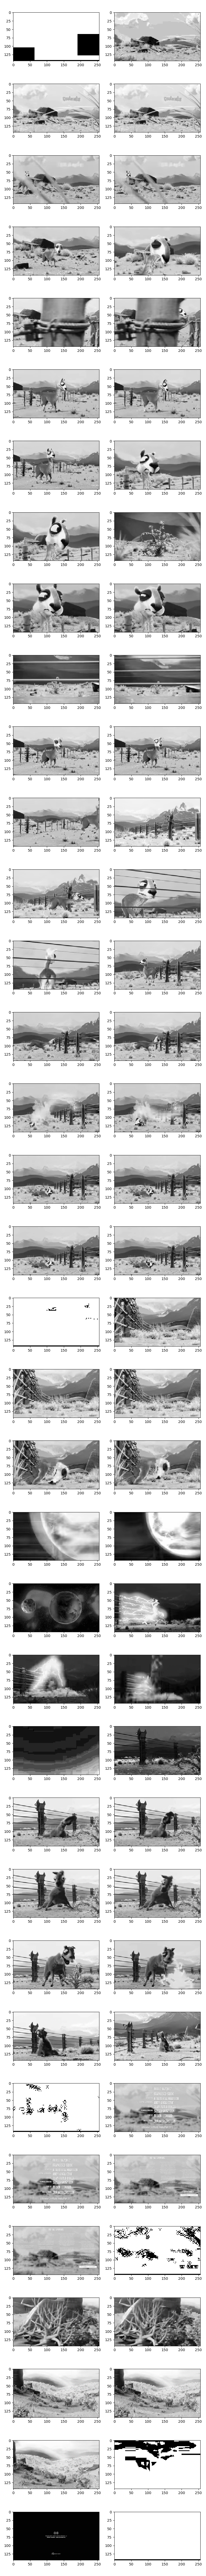

In [18]:
video_length = len(frames)
scene_length_min = 3*fps
scene_length_target = 120*fps
scene_count_target = max(int(video_length/scene_length_target), 1)

sorted_frames_by_hash_diff = list(enumerate(frames_hash_diff))
sorted_frames_by_hash_diff.sort(key=lambda x: x[1], reverse=True)
sorted_frames_by_hash_diff

breakpoints = []
for i in range(scene_count_target):
    for (frame, _) in sorted_frames_by_hash_diff:
        has_near = False
        near = list(filter(lambda x: x < scene_length_min, map(lambda fbp: abs(fbp-frame), breakpoints)))
        if len(near) == 0:
            breakpoints.append(frame)

breakpoints.sort()
print(len(frames), breakpoints)

# Plot

fig, ax = plt.subplots(len(breakpoints), 2, figsize=(8,100))
for i in range(len(breakpoints)):
    point = breakpoints[i]
    ax[i][0].imshow(frames[point-1], cmap='gist_gray')
    ax[i][1].imshow(frames[point], cmap='gist_gray')
plt.tight_layout()

# Hacky way to split segments

<IPython.core.display.Javascript object>


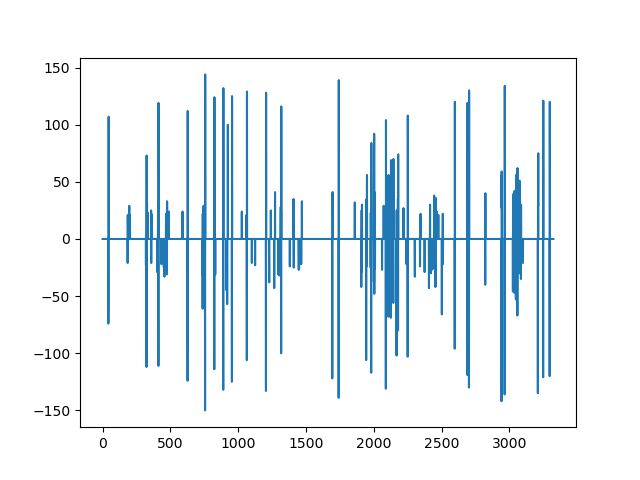

In [31]:
def basic_smoothing(v):
    if abs(v) <= 20:
        return 0
    return v
frames_hash_diff_2 = [0] + [basic_smoothing(frames_hash_diff[i-1]-frames_hash_diff[i]) for i in range(1, len(frames_hash_diff))]

fig, ax1 = plt.subplots(1)
ax1.plot(frames_hash_diff_2)
fig.show()

In [46]:
def hack_split():
    segments = []
    start = None
    end = None
    min_scene_length = 3*fps
    for frame, diff in enumerate(frames_hash_diff_2):
        if diff <= 20:
            if start is None:
                start = frame
            else:
                end = frame
        else:
            if start is not None:
                if end-start >= min_scene_length:
                    segments.append((start, end))
                start = None
    return segments

hack_split()

[(46, 185),
 (203, 324),
 (488, 589),
 (629, 738),
 (1066, 1205),
 (1319, 1407),
 (1471, 1694),
 (1743, 1859),
 (2252, 2344),
 (2510, 2597),
 (2599, 2690),
 (2704, 2822),
 (2824, 2942),
 (3087, 3210)]

<IPython.core.display.Javascript object>


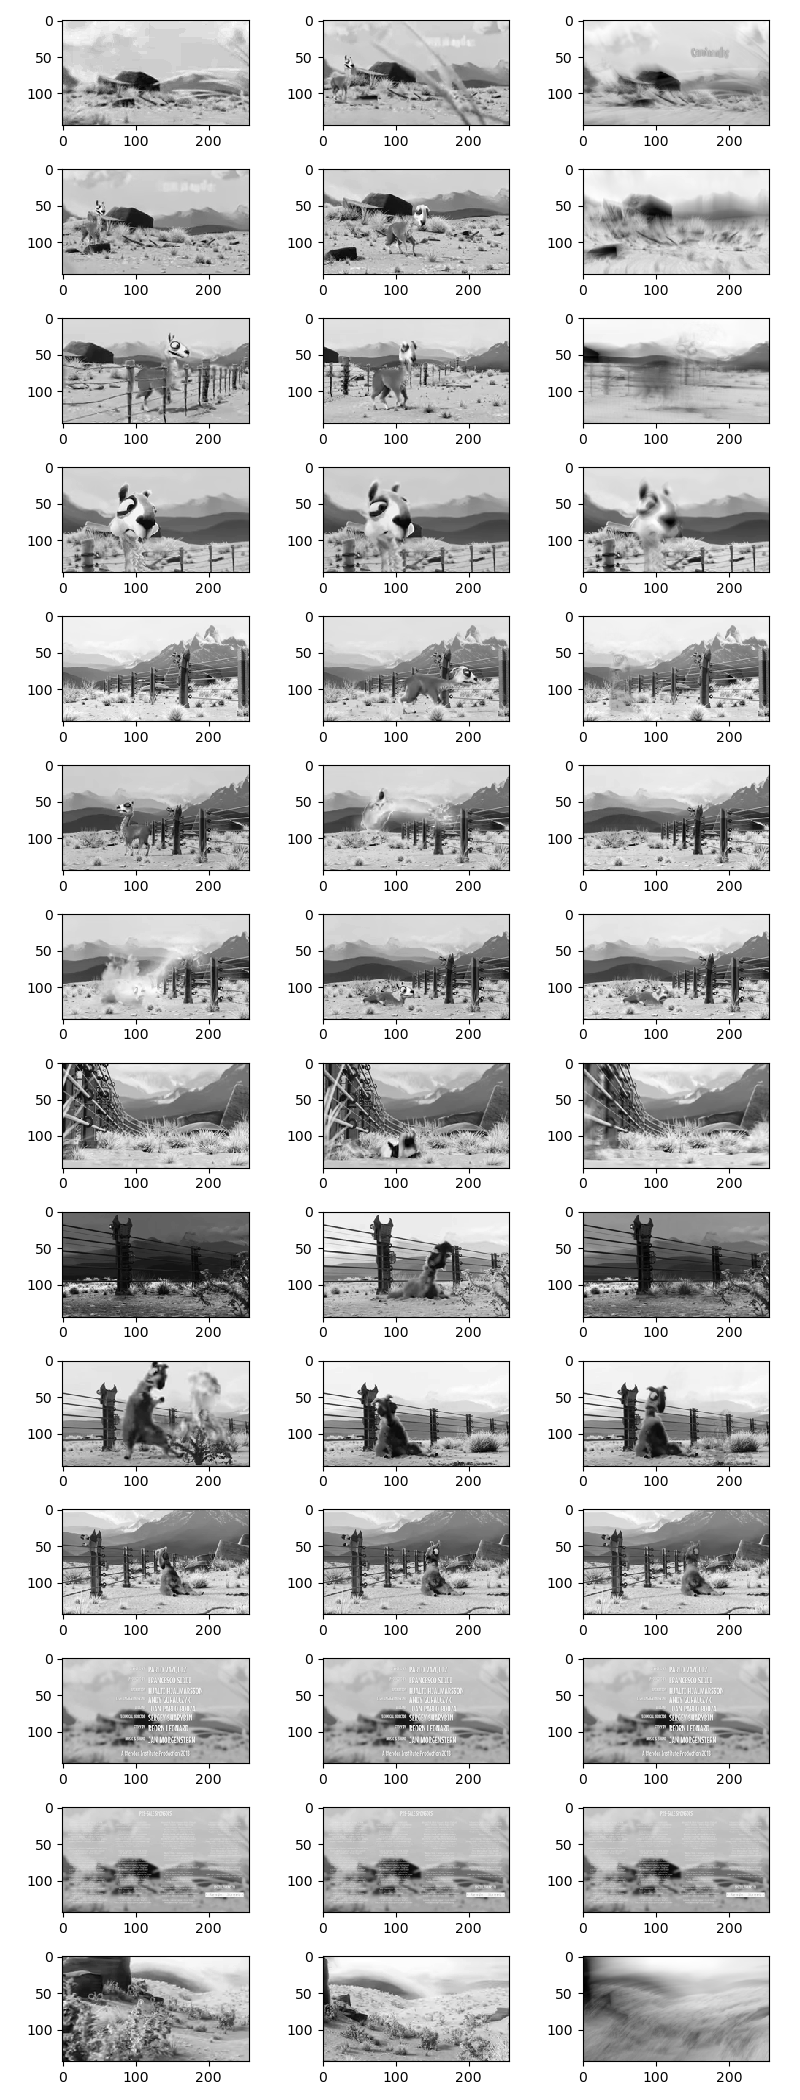

In [56]:
segments = hack_split()

fig, ax = plt.subplots(len(segments), 3, figsize=(8,1.5*len(segments)))
for i, segment in enumerate(segments):
    start, end = segment
    ax[i][0].imshow(frames[start], cmap='gist_gray')
    ax[i][1].imshow(frames[end-1], cmap='gist_gray')
    ax[i][2].imshow(np.average(frames[start:end], axis=0), cmap='gist_gray')
plt.tight_layout()

In [54]:
start, end = segments[0]

np.average(frames[start:end], axis=0)

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.97727273, 0.97727273, 0.97727273, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])